In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.calibration import calibration_curve

2022-06-30 13:25:10.836084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-06-30 13:25:10.836121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

def drawPieChart(label,data,title):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
        ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)
    plt.show()

In [2]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "go01-aw-dl"
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

Setting spark.hadoop.yarn.resourcemanager.principal to oliviermeignan


In [59]:
# Sample usage to run query through spark
#sql = "select * from creditrisk.loan"

#sql="climrisk.european_city_climate_risks ct on (l.country = ct.country and l.city = ct.city)"

loan_df = spark.sql("select * from creditrisk.loan")
clim_df = spark.sql("select country as cl_country, city as cl_city, if(p_tornade>0.01, 1, 0) as tornade, \
                     if (flood_count>1,1,0) as flood from climrisk.european_city_climate_risks")

# Add Climate info to loan
# Add Climate info to loan
columns=['person_age', 'country', 'city', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_type',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y', 'age_type_adult', 'age_type_senior',
       'age_type_young_adult', 'tornade','flood']

sdf=loan_df.join(clim_df, on=[loan_df.country==clim_df.cl_country, loan_df.city==clim_df.cl_city], how='left_outer')\
           .select(columns)



In [60]:
sdf.count()

30104

In [61]:
# Best to reduce df size before to move to Pandas. Here we don't have lot of data. We keep all data
df=sdf.sample(1.0).toPandas()

In [68]:
#loan_df.sample(0.001).count()
df[df.flood > 0]

,person_age,country,city,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,...,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,age_type_adult,age_type_senior,age_type_young_adult,tornade,flood
4,24,ITALY,SAN PIETRO LAMETINO,33996.0,RENT,2.0,EDUCATION,D,5000.0,14.96,...,0,0,0,0,1,0,0,1,0,1
10,23,FRANCE,FELINES TERMENES,42000.0,OWN,7.0,EDUCATION,B,4400.0,11.89,...,0,0,0,1,0,0,0,1,0,1
11,22,FRANCE,CANNES,23800.0,RENT,2.0,PERSONAL,A,8800.0,9.32,...,0,0,0,1,0,0,0,1,0,1
15,21,ITALY,SANTA MARINELLA,36000.0,RENT,3.0,MEDICAL,C,18500.0,10.91,...,0,0,0,1,0,0,0,1,0,1
20,25,FRANCE,REMOULINS,33772.0,RENT,3.0,VENTURE,D,3600.0,16.02,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30088,25,FRANCE,DRAGUIGNAN,30000.0,RENT,4.0,EDUCATION,C,2000.0,14.22,...,0,0,0,1,0,0,0,1,0,1
30091,22,ITALY,BANCHETTE,60000.0,MORTGAGE,5.0,VENTURE,A,5600.0,7.49,...,0,0,0,1,0,0,0,1,0,1
30093,26,FRANCE,ARAMON,71004.0,RENT,0.0,DEBTCONSOLIDATION,D,20000.0,13.36,...,0,0,0,1,0,0,0,1,0,1
30101,24,ITALY,MAZZIN,31000.0,RENT,2.0,EDUCATION,C,10000.0,14.65,...,0,0,0,0,1,0,0,1,0,1


In [31]:
print(df['person_home_ownership'].unique())
indices=df[df['person_home_ownership'].isnull()].index
df.loc[indices,'person_home_ownership']='OTHER'

['MORTGAGE' 'RENT' 'OWN' 'OTHER']


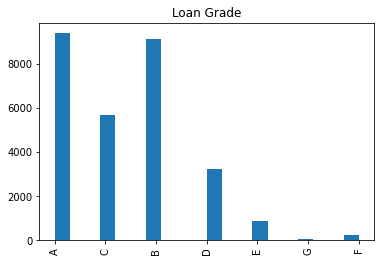

In [32]:
plt.hist(x=df['loan_grade'],bins=20)
plt.xticks(rotation=90)
plt.title("Loan Grade")
plt.show()

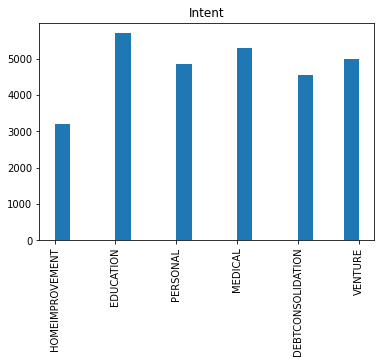

In [33]:
plt.hist(x=df['loan_intent'],bins=20)
plt.xticks(rotation=90)
plt.title("Intent")
plt.show()
#, 'loan_grade'

<AxesSubplot:ylabel='loan_intent-person_age'>

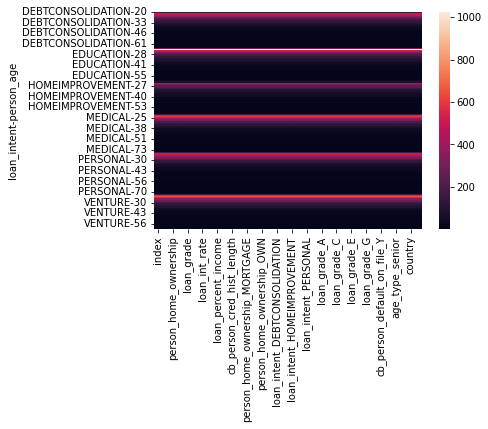

In [34]:
grouped=df.groupby(['loan_intent','person_age']).count()
#print(grouped)
sns.heatmap(grouped)

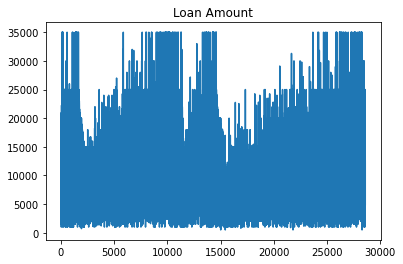

average loan amount 9648.410060868957


In [35]:
df['loan_amnt'].plot()
plt.title('Loan Amount')
plt.show()
print("average loan amount {}".format(df['loan_amnt'].mean()))

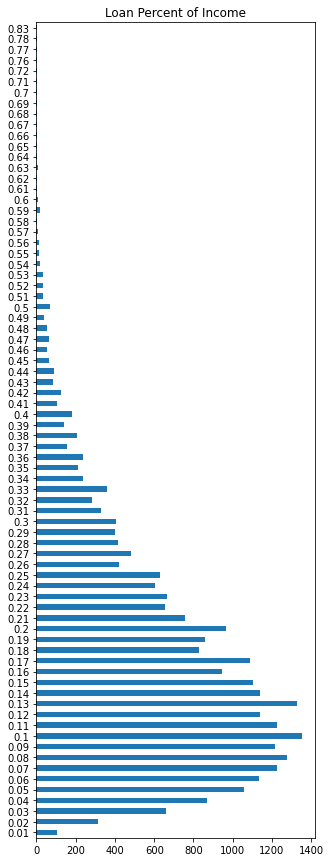

In [36]:
plt.figure(figsize=(5,15))
df['loan_percent_income'].value_counts().sort_index().plot(kind='barh')
plt.title('Loan Percent of Income')
plt.show()

In [37]:
print("Credit risk is the possiblity that the borrower will not repay the loan")

Credit risk is the possiblity that the borrower will not repay the loan


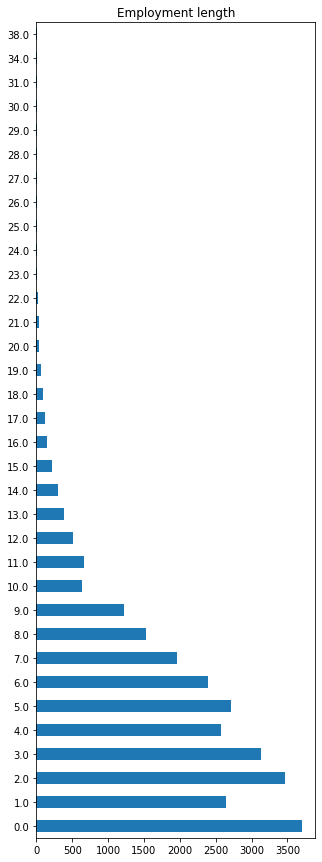

In [38]:
plt.figure(figsize=(5,15))
df['person_emp_length'].value_counts().sort_index().plot(kind='barh')
plt.title("Employment length")
plt.show()

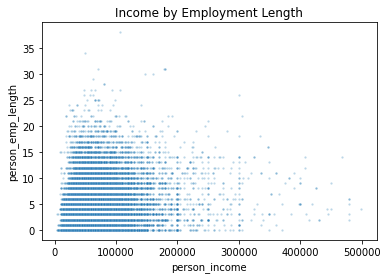

In [39]:
sns.scatterplot(x='person_income',y='person_emp_length',data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

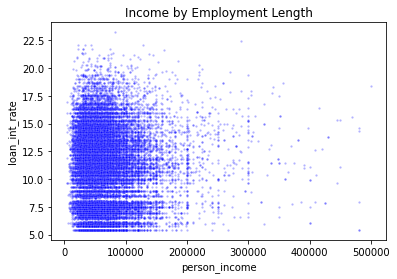

In [40]:
sns.scatterplot(x='person_income',y='loan_int_rate',color="blue", data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

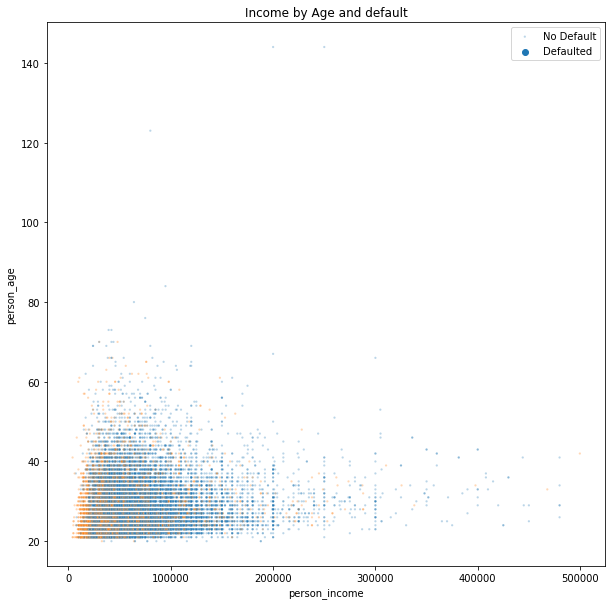

Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency


In [41]:
colors=['red','green']
plt.figure(figsize=(10,10))
sns.scatterplot(x='person_income',y='person_age',hue=df['loan_status'], 
                cmap = ListedColormap(colors),
                data=df,alpha=0.3,s=5)
plt.title('Income by Age and default')
plt.legend(['No Default', 'Defaulted'])
plt.show()

print("Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency")

<Figure size 432x288 with 0 Axes>

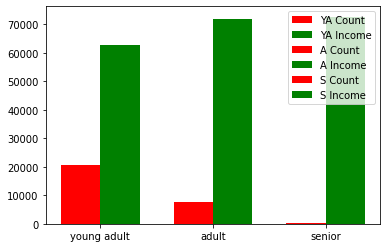

young adult (20-29) adult (30-49), senior (50-)


In [50]:
age_types=['young adult','adult','senior']
grouped=df.groupby('age_type')['person_income'].count()
grouped2=df.groupby('age_type')['person_income'].mean()

young_adult_count=(grouped['young_adult'])
young_adult_income=(grouped2['young_adult'])

adult_count=(grouped['adult'])
adult_income=(grouped2['adult'])

senior_count=(grouped['senior'])
senior_income=(grouped2['senior'])


plt.clf()
bar_width=.35
index=np.arange(len(age_types))
fig,ax=plt.subplots()
ya_count_bar=ax.bar(index[0]-(bar_width/2),young_adult_count,bar_width,label="YA Count",color='red')
ya_income_ba=ax.bar(index[0]+(bar_width/2),young_adult_income,bar_width,label="YA Income",color='green')

a_count_bar=ax.bar(index[1]-(bar_width/2),adult_count,bar_width,label="A Count",color='red')
a_income_ba=ax.bar(index[1]+(bar_width/2),adult_income,bar_width,label="A Income",color='green')

s_count_bar=ax.bar(index[2]-(bar_width/2),senior_count,bar_width,label="S Count",color='red')
s_income_ba=ax.bar(index[2]+(bar_width/2),senior_income,bar_width,label="S Income",color='green')

ax.set_xticks(index)
ax.set_xticklabels(age_types)

#plt.bar(grouped.index,grouped.values,label="Count",color='red')
#plt.bar(grouped2.index,grouped2.values,label="Avg Income", color="green")
plt.legend()

#plt.legend(['young adult (20-29)','adult (30-49), senior (50-)'])
plt.show()
print('young adult (20-29)','adult (30-49), senior (50-)')

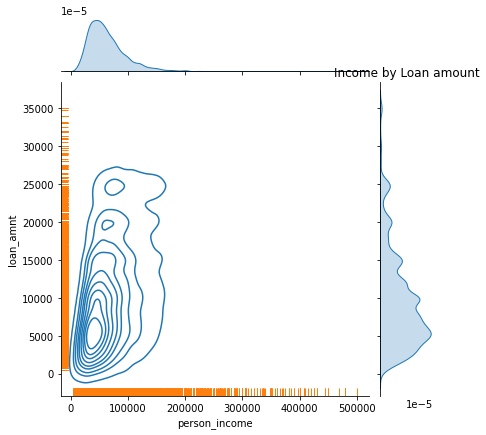

In [51]:
g=sns.JointGrid(data=df, x='person_income', y='loan_amnt')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Income by Loan amount")
plt.show()

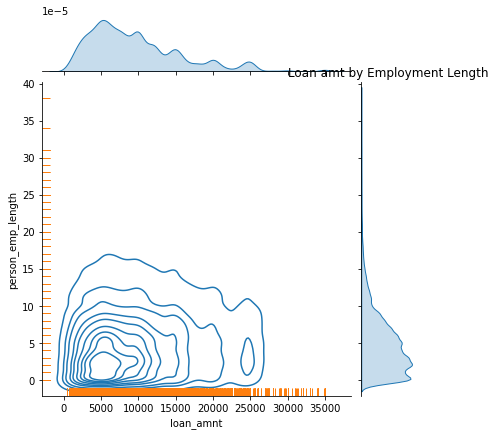

In [52]:
g=sns.JointGrid(data=df, x='loan_amnt', y='person_emp_length')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Loan amt by Employment Length")
plt.show()

/home/cdsw/.local/lib/python3.9/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/home/cdsw/.local/lib/python3.9/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


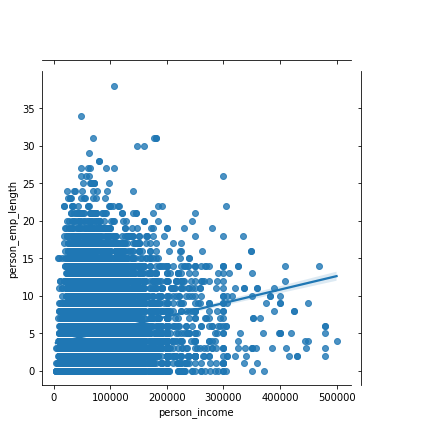

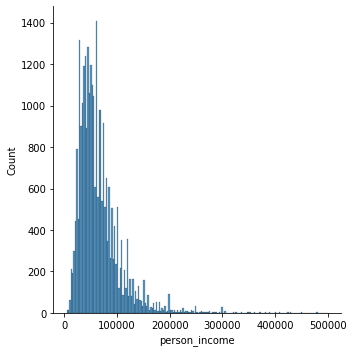

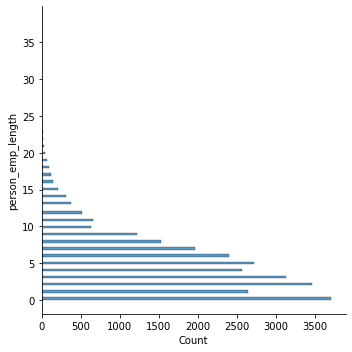

In [53]:
g=sns.JointGrid(data=df, x='person_income', y='person_emp_length')
#g=g.plot_joint(sns.kdeplot)
#g=g.plot_marginals(sns.kdeplot,shade=True)
g.plot(sns.regplot, sns.displot)
plt.show()

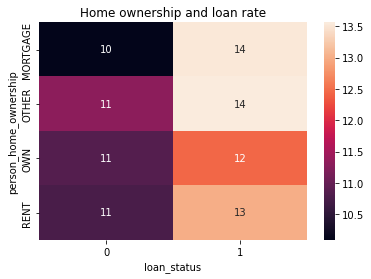

In [54]:
ct=pd.crosstab(df['person_home_ownership'],df['loan_status'],values=df['loan_int_rate'], aggfunc='mean').round(2)
sns.heatmap(ct,annot=True)
plt.title("Home ownership and loan rate")
plt.show()

<AxesSubplot:xlabel='loan_status', ylabel='loan_intent'>

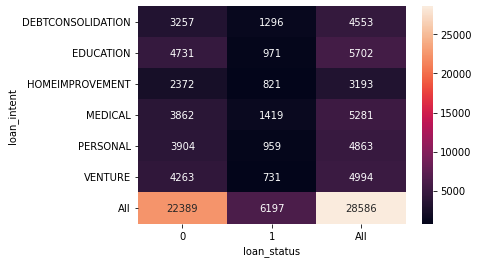

In [55]:
# Create a cross table of the loan intent and loan status
ct=(pd.crosstab(df["loan_intent"], df["loan_status"], margins = True))
sns.heatmap(ct,annot=True,fmt="g")

<AxesSubplot:xlabel='loan_status', ylabel='person_home_ownership'>

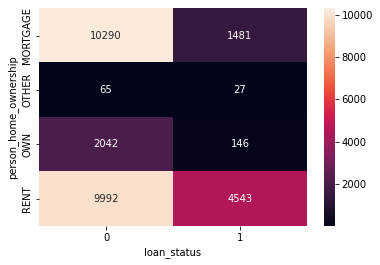

In [56]:
ct=(pd.crosstab(df["person_home_ownership"], df["loan_status"],df["loan_grade"],aggfunc='count'))
sns.heatmap(ct,annot=True,fmt="g")

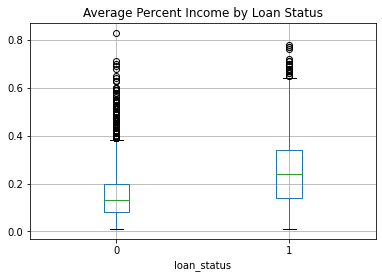

The average percentage of income for defaults is higher


In [57]:
df.boxplot(column = ["loan_percent_income"], by = "loan_status")
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

print("The average percentage of income for defaults is higher")

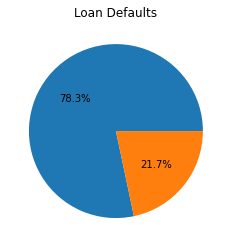

In [58]:
plt.pie(df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title('Loan Defaults')
plt.show()


In [59]:
pipeline = Pipeline([
    #('std', StandardScaler),
    ('lr', LogisticRegression(solver='lbfgs',penalty='l2',C=.1,tol=0.001,max_iter=100))
])

In [60]:
COLUMNS=[x for x in df.select_dtypes(exclude=['object']).columns if x!="loan status"]
print(COLUMNS)
X=df[COLUMNS]

y=df['loan_status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=123)
pipeline['lr'].fit(X_train,y_train)



['index', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N', 'cb_person_default_on_file_Y', 'age_type_adult', 'age_type_senior', 'age_type_young_adult']


LogisticRegression(C=0.1, tol=0.001)

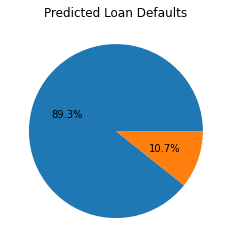

In [61]:
y_pred_prob_lr=pipeline['lr'].predict_proba(X_test)
y_preds_proba_lr_df=pd.DataFrame(y_pred_prob_lr[:,1],columns=["pred_default_proba"])

predictions=pipeline['lr'].predict(X_test)

plt.pie(pd.Series(predictions).value_counts(),autopct='%1.1f%%')
plt.title('Predicted Loan Defaults')
plt.show()


In [62]:
# Function to sort the list by second item of tuple
def Sort_Tuple(tup):
    tup.sort(key = lambda x: float(x[1]), reverse=True)
    return tup

print("Parameters",pipeline['lr'].get_params())
print("Intercept",pipeline['lr'].intercept_)
#print(pipeline['lr'].coef_)

print('\ncoefficients tell us the importance of each feature\n')

feature_coefficients=list(zip(COLUMNS,pipeline['lr'].coef_.T.flatten()))
for feature, coefficient in Sort_Tuple(feature_coefficients):
    print(feature,coefficient)

Parameters {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}
Intercept [-0.00633946]

coefficients tell us the importance of each feature

loan_int_rate 0.20792645957081032
loan_status 0.10263571684702343
loan_grade_D 0.026697498962339604
person_home_ownership_RENT 0.020218995343147885
cb_person_default_on_file_Y 0.01808967572517466
loan_grade_E 0.008331110414228647
loan_intent_DEBTCONSOLIDATION 0.006081930035141842
loan_intent_HOMEIMPROVEMENT 0.0055623519230293
cb_person_cred_hist_length 0.0034717789499150694
loan_intent_MEDICAL 0.003466367250395481
loan_grade_F 0.002156221839310622
loan_grade_G 0.0011033613102503059
age_type_adult 0.0010573147463656496
loan_percent_income 0.0009041696994408447
age_type_senior 0.00034660683496394115
person_home_ownership_OTHER 0.

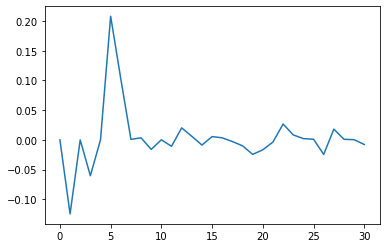

In [63]:
plt.plot(pipeline['lr'].coef_.flatten())

Loss: 2020


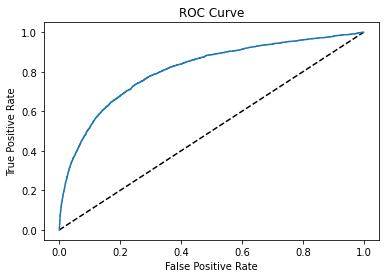

Model Accuracy=82.93
{'The more lift we have the larger the area under the curve'}


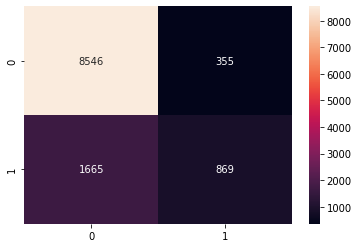

In [64]:
def my_loss(y,w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

print("Loss:",my_loss(np.array(y_test),predictions))

fpr, tpr, threshholds = roc_curve(y_test,y_preds_proba_lr_df)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

accuracy=round(pipeline['lr'].score(X_train, y_train) * 100, 2)

print("Model Accuracy={accuracy}".format(accuracy=accuracy))

cm=confusion_matrix(y_test,predictions)

sns.heatmap(cm,annot=True,fmt="g")

print({"The more lift we have the larger the area under the curve"})

In [65]:
scaler=StandardScaler()
searcher = GridSearchCV(pipeline['lr'], {'C':[0.001, 0.01, 0.1, 1, 10],'tol':[0.001,0.0001,0.01,0.1,0.05,2,3]})
searcher.fit(scaler.fit_transform(X_train), y_train)

print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

Best CV params {'C': 0.01, 'tol': 0.001}
Best CV accuracy 1.0


Text(0.5, 1.0, 'Predictions based on probabilities threshold')

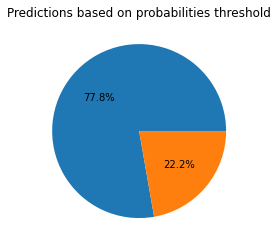

In [66]:
preds_lr = pipeline['lr'].predict_proba(X_test)
lr_test_preds_df = pd.DataFrame(preds_lr[:,1], columns = ['prob_default'])

true_df=y_test
lr_test_preds_df=pd.concat([true_df.reset_index(drop = True), lr_test_preds_df], axis = 1)
#print(preds_df)

#print("Actual defaults ", preds_df['loan_status'][preds_df['loan_status']==1].count())
#print("Predicted defaults ",preds_df['loan_status'][preds_df['prob_default']>=0.50].count())

threshold=0.35
lr_test_preds_df['pred_loan_status']=lr_test_preds_df['prob_default'].apply(lambda x: 1 if x>threshold else 0)
plt.pie(pd.Series(lr_test_preds_df['pred_loan_status']).value_counts(),autopct='%1.1f%%')
plt.title("Predictions based on probabilities threshold")


In [67]:
print(classification_report(y_test,lr_test_preds_df['pred_loan_status'], target_names=['Non default','Default']))

              precision    recall  f1-score   support

 Non default       0.88      0.88      0.88      8901
     Default       0.57      0.57      0.57      2534

    accuracy                           0.81     11435
   macro avg       0.72      0.72      0.72     11435
weighted avg       0.81      0.81      0.81     11435



In [70]:
#https://www.bmc.com/blogs/keras-neural-network-classification/
#model = Sequential()
#model.add(Dense(len(COLUMNS), input_shape=(len(COLUMNS),),
#               activation='tanh'
#               ))
#model.add(Dense(len(COLUMNS),activation='tanh'))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Need to install Graphiz in container. Will do later
#plot_model(model, to_file='model.png')
#img=plt.imread('model.png')
#plt.imshow(img)
#plt.show()


In [71]:
scaler=StandardScaler()
scaler.fit(X)
X2=scaler.transform(X)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(X,y, epochs = 20,verbose=1)
#history=model.fit(X_train,y_train,  epochs = 600)

# Evaluate your model 
print("Final lost value:",model.evaluate(X2,y))



Epoch 1/20
894/894 [==============================] - 2s 1ms/step - loss: 0.4933 - accuracy: 0.7840
Epoch 2/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4656 - accuracy: 0.7972
Epoch 3/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4555 - accuracy: 0.8055
Epoch 4/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4487 - accuracy: 0.8176
Epoch 5/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4470 - accuracy: 0.8233
Epoch 6/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4483 - accuracy: 0.8163
Epoch 7/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4483 - accuracy: 0.8154
Epoch 8/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4428 - accuracy: 0.8267
Epoch 9/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4412 - accuracy: 0.8289
Epoch 10/20
894/894 [==============================] - 1s 1ms/step - loss: 0.4353 - accuracy: 0.8377

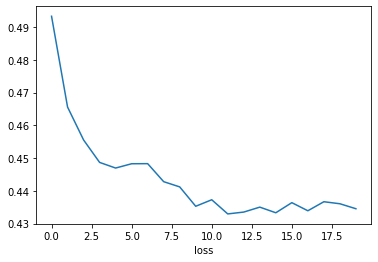

In [72]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('loss')
plt.show()

894/894 [==============================] - 1s 641us/step


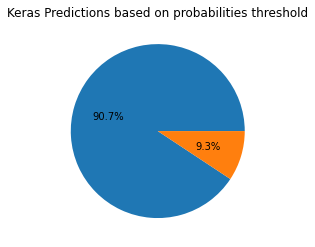

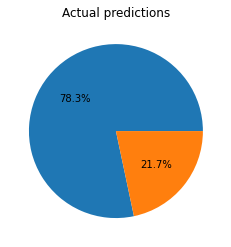

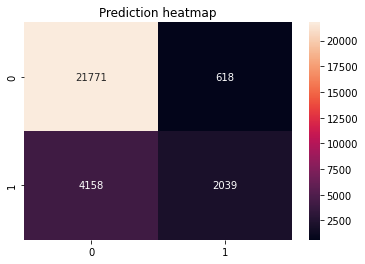

In [73]:
threshold=.54
nn_prediction = model.predict(X[COLUMNS])
#print(nn_prediction)

nn_preds_df = pd.DataFrame(nn_prediction, columns = ['pred_default_proba'])
true_df=y
nn_preds_df=pd.concat([true_df.reset_index(drop = True), nn_preds_df], axis = 1)

nn_preds_df['pred_loan_status']=nn_preds_df['pred_default_proba'].apply(lambda row: 1 if row >threshold else 0)

plt.pie(nn_preds_df['pred_loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Keras Predictions based on probabilities threshold")
plt.show()

plt.pie(nn_preds_df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Actual predictions")
plt.show()    

cm=confusion_matrix(y,nn_preds_df['pred_loan_status'])
sns.heatmap(cm,annot=True,fmt='g')
plt.title('Prediction heatmap')
plt.show()

In [74]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y,nn_preds_df["pred_loan_status"])[0])

print(classification_report(y, nn_preds_df['pred_loan_status'], target_names=['Non default','Default']))

[0.83963901 0.76740685]
              precision    recall  f1-score   support

 Non default       0.84      0.97      0.90     22389
     Default       0.77      0.33      0.46      6197

    accuracy                           0.83     28586
   macro avg       0.80      0.65      0.68     28586
weighted avg       0.82      0.83      0.81     28586



In [75]:
default_count=(X[X['loan_status']==1]['loan_status'].sum())
avg_loan_amt=(X[X['loan_status']==1]['loan_amnt'].mean())

avg_loan_non_default_amt=(X[X['loan_status']==0]['loan_amnt'].mean())

print("Actual Default count {} Avg loan Amt {} Non default avg loant amt {}".format(default_count,avg_loan_amt,avg_loan_non_default_amt))

Actual Default count 6197 Avg loan Amt 11011.110214619977 Non default avg loant amt 9271.231408280852


In [76]:
pred_default_count=nn_preds_df[nn_preds_df['pred_loan_status']==1]['pred_loan_status'].sum()
print("Predicted Default count {}".format(pred_default_count))

Predicted Default count 2657


In [77]:
print("XGBoost Classifier")

XGBoost Classifier


In [78]:
COLUMNS=[x for x in df.select_dtypes(exclude=['object']).columns if x!="loan status"]
X=df[COLUMNS]
y=df['loan_status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=123)



In [79]:
xg_cl= xgb.XGBClassifier(objective='binary:logistic',n_estimators=10,seed=123)

xg_cl.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

Predicted fraud count  2534


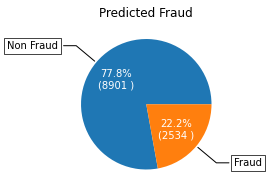

In [80]:
y_pred_xg=xg_cl.predict(X_test)
y_pred_proba_xg=xg_cl.predict_proba(X_test)

y_preds_proba_xg_df = pd.DataFrame(y_pred_proba_xg[:,1], columns = ['prob_default'])


print("Predicted fraud count ",len(y_pred_xg[y_pred_xg==1]))
buffer=pd.Series(y_pred_xg)
#buffer.value_counts().plot(kind='pie')
#plt.show()

drawPieChart(['Non Fraud','Fraud'],buffer.value_counts(),"Predicted Fraud")

xg_preds_df=pd.DataFrame(X_test)
#preds_df=preds_df.reset_index()
#true_df=pd.DataFrame(y_test['loan_status'],columns=['loan_status'])
xg_preds_df=pd.concat([xg_preds_df.reset_index(drop=True),y_preds_proba_xg_df],axis=1)
xg_preds_df.dropna(inplace=True)
#print(preds_df['loan_status'].head())
#for key,item  in preds_df.iterrows():
#    #if item['loan_status']==1:
#    print("{} {} ".format(item['prob_default'],item['person_income']))


In [81]:
# Predict the labels for loan status
gbt_test_preds =xg_cl.predict(X_test)

gbt_test_preds_proba =xg_cl.predict_proba(X_test)
gbt_test_preds_df=pd.DataFrame({"prob_default":gbt_test_preds_proba[:,1],"loan_amnt":X_test['loan_amnt']})
#gbt_test_preds_df=pd.concat(gbt_test_preds_df.reset_index(drop=True),X_test['loan_amnt'].reset_index(drop=True),axis=1)

target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_test_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00      8901
     Default       1.00      1.00      1.00      2534

    accuracy                           1.00     11435
   macro avg       1.00      1.00      1.00     11435
weighted avg       1.00      1.00      1.00     11435



In [82]:

print(xg_cl.get_booster().get_score(importance_type='weight'))

{'loan_status': 10.0}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

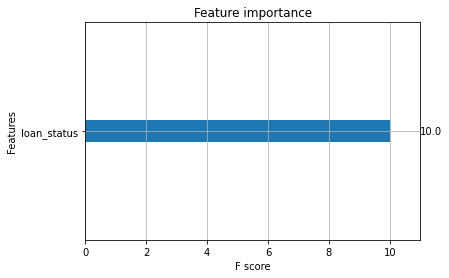

In [83]:
xgb.plot_importance(xg_cl, importance_type='weight')

In [84]:
n_folds=2
early_stop=5

params={'objective':'binary:logistic',
'seed':99, 'eval_metric':'auc'
}

DTrain = xgb.DMatrix(X_train, label=y_train)

xgb.cv(params, DTrain, num_boost_round=5, nfold=n_folds,
early_stopping_rounds=early_stop)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


In [85]:
print(cross_val_score(xg_cl,X_train,y_train,cv=5))

[1. 1. 1. 1. 1.]


In [86]:
COLUMNS2=[x for x in df.select_dtypes(exclude=['object']).columns ]
X_y_train=df[COLUMNS2]

count_non_default, count_default=X_y_train['loan_status'].value_counts()

nondefaults=X_y_train[X_y_train['loan_status']==0]
defaults=X_y_train[X_y_train['loan_status']==1]

nondefaults_under=nondefaults.sample(count_default)

X_y_train_under = pd.concat([nondefaults_under.reset_index(drop=True),defaults.reset_index(drop=True)],axis=0)

a,b=X_y_train_under['loan_status'].value_counts()
print("defaults {} 0 {} 1 {}".format(count_default,a,b))

defaults 6197 0 6197 1 6197


/home/cdsw/.local/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


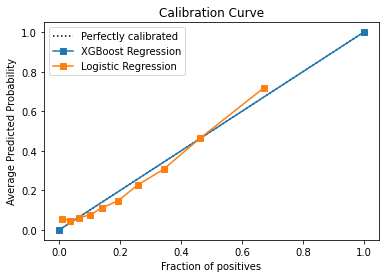

In [87]:
#print(y_pred_proba[:,1])
frac_of_pos, mean_pred_val = calibration_curve(y_test,y_preds_proba_xg_df , n_bins=10, normalize=True,
                                        strategy = 'quantile')

frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test,y_preds_proba_lr_df , n_bins=10, normalize=True,
                                        strategy = 'quantile')



# Create the calibration curve plot with the guideline
plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")    
plt.plot(mean_pred_val, frac_of_pos,
         's-', label='%s' % 'XGBoost Regression')

plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')

plt.xlabel('Fraction of positives')
plt.ylabel('Average Predicted Probability')
plt.legend()

plt.title('Calibration Curve')
plt.show()



In [88]:
threshold= np.quantile(y_preds_proba_xg_df,0.85)
print(threshold)
threshold= np.quantile(y_preds_proba_lr_df,0.85)
print(threshold)

0.9774914979934692
0.4347747628507415


In [89]:
accept_rates=[1.0,0.95,0.90,.80,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]

thresholds=[]
bad_rates=[]

for rate in accept_rates:
    threshold= np.quantile(y_preds_proba_xg_df,rate).round(3)
    thresholds.append(threshold)
    gbt_test_preds_df["pred_loan_status"] = gbt_test_preds_df["prob_default"].apply(lambda x: 1 if x > threshold else 0)
    accepted_loans = gbt_test_preds[gbt_test_preds_df['pred_loan_status'] == 0]
    #bad_rates.append(np.sum(accepted_loans['true_loan_status'] / accepted_loans['true_loan_status'].count()).round(3))
#print(accepted_loans)

xg_strat_df =pd.DataFrame(zip(accept_rates,thresholds),columns=['Acceptance','Thresholds'])
print("Logistic Regression acceptance Strategy")
print(xg_strat_df)

thresholds.clear()

for rate in accept_rates:
    threshold= np.quantile(y_preds_proba_lr_df,rate).round(3)
    thresholds.append(threshold)
    lr_test_preds_df["pred_loan_status"] = lr_test_preds_df["prob_default"].apply(lambda x: 1 if x > threshold else 0)
    accepted_loans = lr_test_preds_df[lr_test_preds_df['pred_loan_status'] == 0]
    #bad_rates.append(np.sum(accepted_loans['true_loan_status'] / accepted_loans['true_loan_status'].count()).round(3))
#print(accepted_loans)

lr_strat_df =pd.DataFrame(zip(accept_rates,thresholds),columns=['Acceptance','Thresholds'])
print("Logistic Regression acceptance Strategy ")
print(lr_strat_df)




Logistic Regression acceptance Strategy
    Acceptance  Thresholds
0         1.00       0.977
1         0.95       0.977
2         0.90       0.977
3         0.80       0.977
4         0.75       0.022
5         0.70       0.022
6         0.65       0.022
7         0.60       0.022
8         0.55       0.022
9         0.50       0.022
10        0.45       0.022
11        0.40       0.022
12        0.35       0.022
13        0.30       0.022
14        0.25       0.022
15        0.20       0.022
16        0.15       0.022
17        0.10       0.022
18        0.05       0.022
Logistic Regression acceptance Strategy 
    Acceptance  Thresholds
0         1.00       0.946
1         0.95       0.615
2         0.90       0.514
3         0.80       0.374
4         0.75       0.322
5         0.70       0.280
6         0.65       0.243
7         0.60       0.211
8         0.55       0.181
9         0.50       0.156
10        0.45       0.134
11        0.40       0.113
12        0.35       0.094
1

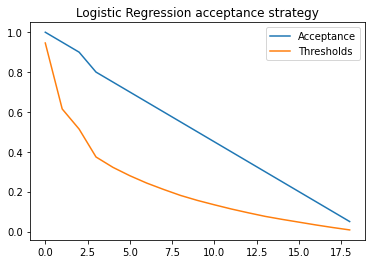

The higher acceptance rates require higher threshholds


In [90]:
lr_strat_df.plot()
plt.title("Logistic Regression acceptance strategy")
plt.show()

print("The higher acceptance rates require higher threshholds")

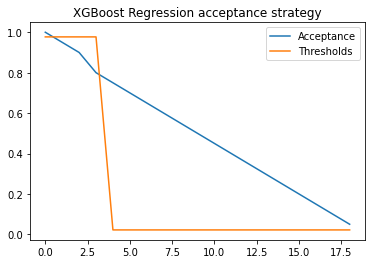

In [91]:
xg_strat_df.plot()
plt.title("XGBoost Regression acceptance strategy")
plt.show()

In [92]:
#print(gbt_test_preds_df.head())
lgd=1
# Calculate the bank's expected loss and assign it to a new column
gbt_test_preds_df['expected_loss'] = gbt_test_preds_df['prob_default'] * gbt_test_preds_df['loan_amnt'] * lgd

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(gbt_test_preds_df['expected_loss']),2)
total_loan_amnt= round(np.sum(gbt_test_preds_df['loan_amnt']),2)
print('Total expected loss: ${:,.2f} total loan ${:,.2f} '.format(tot_exp_loss,total_loan_amnt))

Total expected loss: $29,167,767.99 total loan $110,338,075.00 
